In [ ]:
#-------------NOW-----------------
#CURRENT PLAYER STATS
#CURRENT FIXTURE
#PAST FIXTURE
#PAST 3 FIXTURES

#--------------NEXT STEPS
#ELEMENT TYPE STATS
#PAST YEAR PERFORMANCE OF PLAYERS
#CHANCE OF PLAYING THIS ROUND AND NEXT

In [16]:
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVR
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

with open('player_details.json') as json_data:
    d = json.load(json_data)
history = json_normalize(d, 'history', ['player_id'])
past = json_normalize(d, 'history_past', ['player_id'])
playerInfo = pd.read_json('players.json',orient='columns')
fixtures =  json_normalize(d, 'fixtures', ['player_id'])
teams = pd.read_json('teams.json',orient='columns')

player_type = pd.read_json('game-settings.json',orient='index')
player_type['element_type'] = player_type.index

In [5]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [6]:
def dataPrep (data,curr,past,past_avg,prepType):
    
    player_type.columns = ['et_bps_clean_sheets','et_bps_goals_scored','et_scoring_clean_sheets','et_scoring_goals_conceded','et_scoring_goals_scored','et_squad_max_play',
                 'et_squad_min_play','et_squad_select','et_sub_positions_locked','et_ui_shirt_specific','element_type']

    player_t=player_type[['et_bps_clean_sheets','et_bps_goals_scored','et_scoring_clean_sheets','et_scoring_goals_conceded','et_scoring_goals_scored','et_squad_max_play',
                 'et_squad_min_play','et_squad_select','element_type' ]]

    data = data.merge(player_t,how='left',on='element_type')

    teams.columns = ['team_code', 'current_event_fixture','draw','form','team'
                              ,'link_url','loss','team_name','next_event_fixture','played','points'
                              ,'position','short_team_name','strength','strength_attack_away',
                              'strength_attack_home','strength_defence_away','strength_defence_home','strength_overall_away',
                          'strength_overall_home','team_division','unavailable','win']

    teams_n=teams[['team','strength','strength_attack_away','strength_defence_away','strength_overall_away',
                   'strength_attack_home','strength_defence_home','strength_overall_home','short_team_name' ]]
    le = LabelEncoder()
    val_col = ['short_team_name']
    for i in val_col:
        teams_n[i] = le.fit_transform(teams_n[i])
    data = data.merge(teams_n,how='left',on='team')
    
    #Current Fixture
    if prepType == 'Train':
        current_fix = history.query('round=='+str(curr))
        current_fix.columns = ['curr_assists', 'curr_attempted_passes', 'curr_big_chances_created',
               'curr_big_chances_missed', 'curr_bonus', 'curr_bps', 'curr_clean_sheets',
               'curr_clearances_blocks_interceptions', 'curr_completed_passes', 'curr_creativity',
               'curr_dribbles', 'curr_ea_index', 'curr_element', 'curr_errors_leading_to_goal',
               'curr_errors_leading_to_goal_attempt', 'curr_fixture', 'curr_fouls', 'curr_goals_conceded',
               'curr_goals_scored', 'curr_ict_index', 'curr_id', 'curr_influence', 'curr_key_passes',
               'curr_kickoff_time', 'curr_kickoff_time_formatted', 'curr_loaned_in', 'curr_loaned_out',
               'curr_minutes', 'curr_offside', 'curr_open_play_crosses', 'curr_opponent_team', 'curr_own_goals',
               'curr_penalties_conceded', 'curr_penalties_missed', 'curr_penalties_saved',
               'curr_recoveries', 'curr_red_cards', 'curr_round', 'curr_saves', 'curr_selected', 'curr_tackled',
               'curr_tackles', 'curr_target_missed', 'curr_team_a_score', 'curr_team_h_score', 'curr_threat',
               'curr_total_points', 'curr_transfers_balance', 'curr_transfers_in', 'curr_transfers_out',
               'curr_value', 'curr_was_home', 'curr_winning_goals', 'curr_yellow_cards', 'id']
        current_fix=current_fix[[
               'curr_opponent_team', 'curr_was_home', 'id']]
        #data = data.merge(current_fix,how='left',on='id')
    elif prepType == 'Real':
        current_fix = fixtures.query('event=='+str(curr))
        current_fix.columns = ['fut_id', 'fut_kickoff_time_formatted','fut_event_name','curr_opponent_name','fut_opponent_short_name'
                              ,'curr_was_home','fut_difficulty','fut_code','fut_kickoff_time','fut_team_h_score','fut_team_a_score'
                              ,'fut_finished','fut_minutes','fut_provisional_start_time','fut_finished_provisional',
                              'fut_event','fut_team_a','fut_team_h','id']

        current_fix=current_fix[[
               'curr_opponent_name',
               'curr_was_home', 'id']]
        #data = data.merge(future_fix,how='left',on='id')
    le = LabelEncoder()
    current_fix['id'] = le.fit_transform(data['id'])
    current_fix =current_fix[current_fix.id != 0]
    current_fix = current_fix.merge(data[['id','team']],how='left',on='id')
    team_diff = current_fix.merge(teams_n,how='left',on=['team'])
    team_diff.columns = ['curr_opponent_team', 'curr_was_home', 'id','team','curr_strength','curr_strength_attack_away',
                              'curr_strength_attack_home','curr_strength_defence_away','curr_strength_defence_home','curr_strength_overall_away',
                              'curr_strength_overall_home','curr_short_team_name']
    team_diff = team_diff.merge(teams_n,how='left',left_on=['curr_opponent_team'], right_on=['team'])
    team_diff.columns = ['curr_opponent_team', 'curr_was_home', 'id','team','team_strength','curr_strength_attack_away',
                              'curr_strength_attack_home','curr_strength_defence_away','curr_strength_defence_home','curr_strength_overall_away',
                              'curr_strength_overall_home','curr_short_team_name','opp_team',
                              'opp_strength','curr_opp_strength_attack_away','curr_opp_strength_attack_home',
                              'curr_opp_strength_defence_away','curr_opp_strength_defence_home','curr_opp_strength_overall_away',
                              'curr_opp_strength_overall_home','curr_opp_short_team_name']
    team_diff['strength_diff'] = team_diff['team_strength']-team_diff['opp_strength']
    team_diff['strength_attack_diff'] = np.where(team_diff['curr_was_home']==True, team_diff['curr_strength_attack_home']-team_diff['curr_opp_strength_attack_away'], team_diff['curr_strength_attack_away']-team_diff['curr_opp_strength_attack_home'])
    team_diff['strength_defence_diff'] = np.where(team_diff['curr_was_home']==True, team_diff['curr_strength_defence_home']-team_diff['curr_opp_strength_defence_away'], team_diff['curr_strength_defence_away']-team_diff['curr_opp_strength_defence_home'])
    team_diff['strength_overall_diff'] = np.where(team_diff['curr_was_home']==True, team_diff['curr_strength_overall_home']-team_diff['curr_opp_strength_overall_away'], team_diff['curr_strength_overall_away']-team_diff['curr_opp_strength_overall_home'])
    team_diff = team_diff[['curr_opponent_team', 'curr_was_home', 'id','strength_diff','strength_attack_diff',
                           'strength_defence_diff','strength_overall_diff']]
    data = data.merge(team_diff,how='left',on='id')

    #Past Fixture   
    past_fix_avg = history.query('round>='+str(past_avg)+' & round <='+str(past))
    past_fix_avg.columns = ['prev_assists3', 'prev_attempted_passes3', 'prev_big_chances_created3',
           'prev_big_chances_missed3', 'prev_bonus3', 'prev_bps3', 'prev_clean_sheets3',
           'prev_clearances_blocks_interceptions3', 'prev_completed_passes3', 'prev_creativity3',
           'prev_dribbles3', 'prev_ea_index3', 'prev_element3', 'prev_errors_leading_to_goal3',
           'prev_errors_leading_to_goal_attempt3', 'prev_fixture3', 'prev_fouls3', 'prev_goals_conceded3',
           'prev_goals_scored3', 'prev_ict_index3', 'prev_id3', 'prev_influence3', 'prev_key_passes3',
           'prev_kickoff_time3', 'prev_kickoff_time_formatted3', 'prev_loaned_in3', 'prev_loaned_out3',
           'prev_minutes3', 'prev_offside3', 'prev_open_play_crosses3', 'prev_opponent_team3', 'prev_own_goals3',
           'prev_penalties_conceded3', 'prev_penalties_missed3', 'prev_penalties_saved3',
           'prev_recoveries3', 'prev_red_cards3', 'prev_round3', 'prev_saves3', 'prev_selected3', 'prev_tackled3',
           'prev_tackles3', 'prev_target_missed3', 'prev_team_a_score3', 'prev_team_h_score3', 'prev_threat3',
           'prev_total_points3', 'prev_transfers_balance3', 'prev_transfers_in3', 'prev_transfers_out3',
           'prev_value3', 'prev_was_home3', 'prev_winning_goals3', 'prev_yellow_cards3', 'id']
    past_fix_avg=past_fix_avg[['prev_assists3', 'prev_attempted_passes3', 'prev_big_chances_created3',
           'prev_big_chances_missed3', 'prev_bonus3', 'prev_bps3', 'prev_clean_sheets3',
           'prev_clearances_blocks_interceptions3', 'prev_completed_passes3', 'prev_creativity3',
           'prev_dribbles3', 'prev_ea_index3', 'prev_element3', 'prev_errors_leading_to_goal3',
           'prev_errors_leading_to_goal_attempt3',  'prev_fouls3', 'prev_goals_conceded3',
           'prev_goals_scored3', 'prev_ict_index3',  'prev_influence3', 'prev_key_passes3',
           'prev_kickoff_time_formatted3', 
           'prev_minutes3', 'prev_offside3', 'prev_open_play_crosses3', 'prev_opponent_team3', 'prev_own_goals3',
           'prev_penalties_conceded3', 'prev_penalties_missed3', 'prev_penalties_saved3',
           'prev_recoveries3', 'prev_red_cards3', 'prev_round3', 'prev_saves3',  'prev_tackled3',
           'prev_tackles3', 'prev_target_missed3', 'prev_team_a_score3', 'prev_team_h_score3', 'prev_threat3',
           'prev_total_points3',
           'prev_value3', 'prev_was_home3', 'prev_winning_goals3', 'prev_yellow_cards3', 'id']]
    var_col = ['prev_kickoff_time_formatted3','prev_was_home3','prev_threat3', 'prev_influence3','prev_creativity3','prev_ict_index3']
    le = LabelEncoder()
    for i in var_col:
        past_fix_avg[i] = le.fit_transform(past_fix_avg[i])
    #past_fix_avg = past_fix_avg.merge(teams_n,how='left',left_on=['prev_opponent_team3'], right_on=['team'])
    past_fix_avg= past_fix_avg.groupby(['id'], as_index=False).mean()
    data = data.merge(past_fix_avg,how='left',on='id')
    
    var_mod = ['photo','web_name','status','first_name','second_name','in_dreamteam','special','news']
    le = LabelEncoder()
    for i in var_mod:
        data[i] = le.fit_transform(data[i])

    data.fillna(0.0,inplace=True)
    data['chance_of_playing_next_round'].fillna(100.0,inplace=True)
    data['chance_of_playing_this_round'].fillna(100.0,inplace=True)
    return data

In [7]:
#Generic function for making a classification model and accessing performance:
def classification_model(model, data, X, y):
  #Make predictions on training set:
  predictions = []
  model.fit(X,y)
  predictions = model.predict(X)
  accuracy = metrics.accuracy_score(predictions,y)
  print ("Accuracy : %s" % "{0:.3%}".format(accuracy))
  
  #Perform k-fold cross-validation with 5 folds
  kf = KFold(data.shape[0],n_folds=5)
  error = []
  for train, test in kf:
    # Filter training data
    train_predictors = (X.iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = y.iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(X.iloc[test,:], y.iloc[test]))
 
  print ("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

  #Fit the model again so that it can be refered outside the function:
  model.fit(X,y) 

In [8]:
#playerInfo = playerInfo.query('element_type==4')
train_data = dataPrep(playerInfo,7,6,1,'Train')
outcome_var = 'event_points'
predictor_var_all = [
'chance_of_playing_this_round', 
'element_type','et_bps_clean_sheets','et_bps_goals_scored','et_scoring_clean_sheets',
'et_scoring_goals_conceded','et_scoring_goals_scored','et_squad_max_play','et_squad_min_play','et_squad_select',
'status', 
'team','strength','strength_attack_away',
'strength_attack_home','strength_defence_away','strength_defence_home','strength_overall_away',
'strength_overall_home','short_team_name',
'curr_opponent_team', 'curr_was_home','strength_diff','strength_attack_diff',
'strength_defence_diff','strength_overall_diff',
'prev_assists3', 'prev_attempted_passes3', 'prev_big_chances_created3',
'prev_big_chances_missed3', 'prev_bonus3', 'prev_bps3', 'prev_clean_sheets3',
'prev_clearances_blocks_interceptions3', 'prev_completed_passes3', 
'prev_dribbles3', 'prev_ea_index3', 'prev_element3', 'prev_errors_leading_to_goal3',
'prev_errors_leading_to_goal_attempt3',  'prev_fouls3', 'prev_goals_conceded3',
'prev_goals_scored3', 'prev_key_passes3',
'prev_ict_index3',  'prev_influence3', 'prev_creativity3','prev_threat3',
'prev_kickoff_time_formatted3', 
'prev_minutes3', 'prev_offside3', 'prev_open_play_crosses3', 'prev_opponent_team3', 'prev_own_goals3',
'prev_penalties_conceded3', 'prev_penalties_missed3', 'prev_penalties_saved3',
'prev_recoveries3', 'prev_red_cards3', 'prev_round3', 'prev_saves3',  'prev_tackled3',
'prev_tackles3', 'prev_target_missed3', 'prev_team_a_score3', 'prev_team_h_score3',
'prev_total_points3','prev_value3', 'prev_was_home3', 'prev_winning_goals3', 'prev_yellow_cards3']

C:\Users\hassouda\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
train_data.shape

(554, 124)

In [10]:
model = LogisticRegression()
classification_model(model, train_data,train_data[predictor_var_all],train_data[outcome_var])


Accuracy : 56.137%
Cross-Validation Score : 47.651%


In [24]:
scaler = StandardScaler()
X = scaler.fit_transform(train_data[predictor_var_all])
Xnew = pd.DataFrame(X)

model2 = svm.SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
classification_model(model2, train_data,Xnew,train_data[outcome_var])
#Create a series with feature importances:
#featimp = pd.Series(model2.feature_importances_, index=predictor_var_all).sort_values(ascending=False)
#print (featimp)

Accuracy : 72.022%
Cross-Validation Score : 44.583%


In [23]:
from sklearn.model_selection import GridSearchCV
params_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
          'gamma': [0.0001, 0.001, 0.01, 0.1],
          'kernel':['rbf'] }
#Create the GridSearchCV object
grid_clf = GridSearchCV(svm.SVC(class_weight='balanced'), params_grid)

#Fit the data with the best possible parameters
grid_clf = grid_clf.fit(Xnew, train_data[outcome_var])

#Print the best estimator with it's parameters
print (grid_clf.best_estimator_)

C:\Users\hassouda\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [136]:
model3 = DecisionTreeClassifier()
classification_model(model3, train_data,train_data[predictor_var_all],train_data[outcome_var])
#Create a series with feature importances:
#featimp = pd.Series(model3.feature_importances_, index=predictor_var_all).sort_values(ascending=False)
#print (featimp)

Accuracy : 78.520%
Cross-Validation Score : 44.244%


In [139]:
model4 = RandomForestClassifier(n_estimators = 30,max_depth=7)#,max_features='log2')
classification_model(model4, train_data,train_data[predictor_var_all],train_data[outcome_var])
#Create a series with feature importances:
featimp = pd.Series(model4.feature_importances_, index=predictor_var_all).sort_values(ascending=False)
print (featimp)

Accuracy : 67.870%
Cross-Validation Score : 51.097%
status                                  0.216103
chance_of_playing_this_round            0.083307
curr_opponent_team                      0.056115
strength_attack_diff                    0.053170
strength_defence_diff                   0.053050
strength_overall_diff                   0.052703
short_team_name                         0.049069
team                                    0.041306
strength_overall_home                   0.036567
strength_defence_away                   0.035716
strength_defence_home                   0.032141
strength_overall_away                   0.032051
element_type                            0.026704
strength_attack_home                    0.025495
strength_diff                           0.024922
strength_attack_away                    0.022564
et_bps_clean_sheets                     0.021165
et_scoring_goals_scored                 0.021068
et_squad_min_play                       0.017676
curr_was_home    

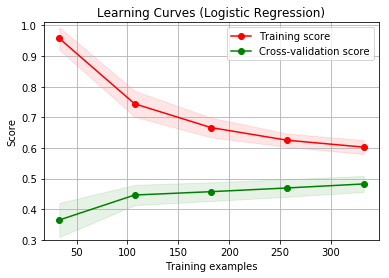

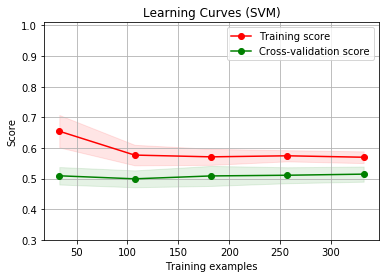

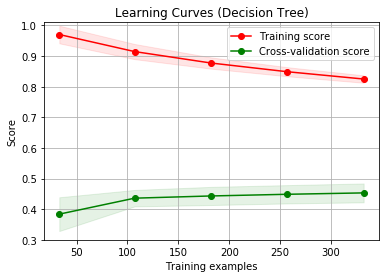

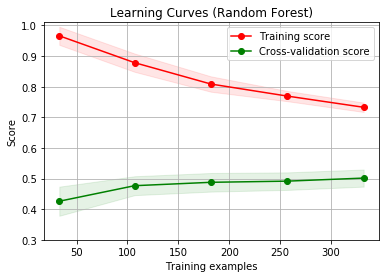

In [140]:
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=50, test_size=0.4, random_state=0)
plot_learning_curve(model, title, train_data[predictor_var_all], train_data[outcome_var], ylim=(0.3, 1.01), cv=cv)

title = "Learning Curves (SVM)"
cv = ShuffleSplit(n_splits=10, test_size=0.4, random_state=0)
plot_learning_curve(model2, title, train_data[predictor_var_all], train_data[outcome_var], ylim=(0.3, 1.01), cv=cv)

title = "Learning Curves (Decision Tree)"
cv = ShuffleSplit(n_splits=50, test_size=0.4, random_state=0)
plot_learning_curve(model3, title, train_data[predictor_var_all], train_data[outcome_var], ylim=(0.3, 1.01), cv=cv)

title = "Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=50, test_size=0.4, random_state=0)
plot_learning_curve(model4, title, train_data[predictor_var_all], train_data[outcome_var], ylim=(0.3, 1.01), cv=cv)

plt.show()

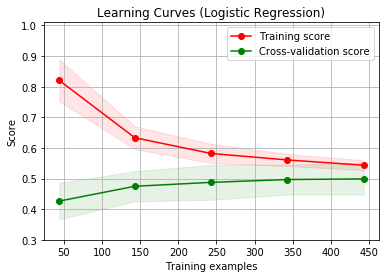

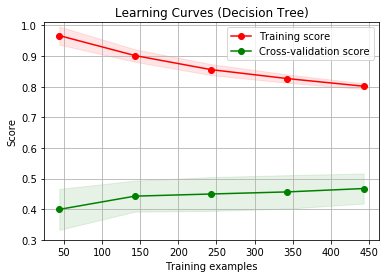

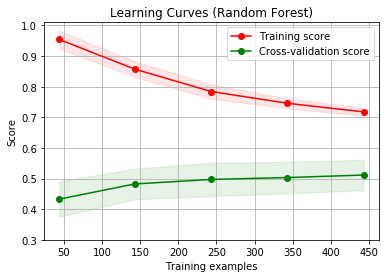

In [141]:
from sklearn.feature_selection import SelectFromModel

title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
m = SelectFromModel(model, prefit=True)
X_new = m.transform(train_data[predictor_var_all])
Xnew = pd.DataFrame(X_new)
plot_learning_curve(model, title, Xnew, train_data[outcome_var], ylim=(0.3, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (Decision Tree)"
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
m = SelectFromModel(model3, prefit=True)
X_new = m.transform(train_data[predictor_var_all])
Xnew = pd.DataFrame(X_new)
plot_learning_curve(model3, title, Xnew, train_data[outcome_var], ylim=(0.3, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
m = SelectFromModel(model4, prefit=True)
X_new = m.transform(train_data[predictor_var_all])
Xnew = pd.DataFrame(X_new)
plot_learning_curve(model4, title, Xnew, train_data[outcome_var], ylim=(0.3, 1.01), cv=cv, n_jobs=4)

plt.show()

In [80]:
real_data = dataPrep(playerInfo,8,7,5,'Real')
predictor_var_all2 = [
    'assists', 'bonus', 'bps', 'chance_of_playing_next_round',
        'clean_sheets',
       'cost_change_event', 'cost_change_event_fall', 'cost_change_start',
       'cost_change_start_fall', 'creativity', 'dreamteam_count', 'ea_index',
       'element_type', 
       'goals_conceded', 'goals_scored',  
       'in_dreamteam', 'influence', 
       'minutes',  'own_goals',
       'penalties_missed', 'penalties_saved',  'points_per_game',
       'red_cards', 'saves',
       'squad_number', 'status', 'team', 'threat', 'total_points',
       'value_season',
       'yellow_cards',
       'fut_opponent_name', 
       'now_cost', 'fut_is_home','prev_assists', 'prev_attempted_passes', 'prev_big_chances_created',
       'prev_big_chances_missed', 'prev_bonus', 'prev_bps', 'prev_clean_sheets',
       'prev_clearances_blocks_interceptions', 'prev_completed_passes', 'prev_creativity',
       'prev_dribbles', 'prev_ea_index','prev_errors_leading_to_goal',
       'prev_errors_leading_to_goal_attempt',  'prev_fouls', 'prev_goals_conceded',
       'prev_goals_scored', 'prev_ict_index',  'prev_influence', 'prev_key_passes',
        'prev_kickoff_time_formatted', 
       'prev_minutes', 'prev_offside', 'prev_open_play_crosses', 'prev_opponent_team', 'prev_own_goals',
       'prev_penalties_conceded', 'prev_penalties_missed', 'prev_penalties_saved',
       'prev_recoveries', 'prev_red_cards', 'prev_round', 'prev_saves',  'prev_tackled',
       'prev_tackles', 'prev_target_missed', 'prev_team_a_score', 'prev_team_h_score', 'prev_threat',
       'prev_total_points',
       'prev_value', 'prev_was_home', 'prev_winning_goals', 'prev_yellow_cards',
       'prev_assists3', 'prev_attempted_passes3', 'prev_big_chances_created3',
       'prev_big_chances_missed3', 'prev_bonus3', 'prev_bps3', 'prev_clean_sheets3',
       'prev_clearances_blocks_interceptions3', 'prev_completed_passes3', 'prev_creativity3',
       'prev_dribbles3', 'prev_ea_index3', 'prev_errors_leading_to_goal3',
       'prev_errors_leading_to_goal_attempt3',  'prev_fouls3', 'prev_goals_conceded3',
       'prev_goals_scored3', 'prev_ict_index3',  'prev_influence3', 'prev_key_passes3',
        'prev_kickoff_time_formatted3', 
       'prev_minutes3', 'prev_offside3', 'prev_open_play_crosses3', 'prev_opponent_team3', 'prev_own_goals3',
       'prev_penalties_conceded3', 'prev_penalties_missed3', 'prev_penalties_saved3',
       'prev_recoveries3', 'prev_red_cards3', 'prev_round3', 'prev_saves3', 'prev_tackled3',
       'prev_tackles3', 'prev_target_missed3', 'prev_team_a_score3', 'prev_team_h_score3', 'prev_threat3',
       'prev_total_points3', 
       'prev_value3', 'prev_was_home3', 'prev_winning_goals3', 'prev_yellow_cards3']
linear = model.predict(real_data[predictor_var_all2])
SVR = model2.predict(real_data[predictor_var_all2])
tree = model3.predict(real_data[predictor_var_all2])
random = model4.predict(real_data[predictor_var_all2])

In [81]:
with open('team_details.json') as json_data:
    d = json.load(json_data)
picks = json_normalize(d, 'picks')
picks.columns = ['can_captain','can_sub','id','has_played','is_captain','is_sub','is_vice_captain','multiplier','position',
                 'selling_price']

player_name = pd.read_json('players.json',orient='columns')
my_players = player_name.merge(picks,how='inner',on='id')
columns_C = ['ID','Position','Name', 'Linear Points', 'Tree Points','Random Forest Points','Multiplier','Sub','Linear_total','Tree_total','Random_total']

datax = []
for index, row in my_players.iterrows():
    sel_row = []
    sel_row.append(str(row['id']))
    sel_row.append(str(row['position']))
    sel_row.append(str(row['first_name']+' '+row['second_name']))
    sel_row.append(str(linear[row['id']-1]))
    sel_row.append(str(tree[row['id']-1]))
    sel_row.append(str(random[row['id']-1]))
    sel_row.append(str(row['multiplier']))
    sel_row.append(str(row['is_sub']))
    if row['is_sub']:
        sel_row.append(0)
    else:
        sel_row.append(linear[row['id']-1]*row['multiplier'])
    if row['is_sub']:
        sel_row.append(0)
    else:
        sel_row.append(tree[row['id']-1]*row['multiplier'])
    if row['is_sub']:
        sel_row.append(0)
    else:
        sel_row.append(random[row['id']-1]*row['multiplier'])
    datax.append(sel_row)
pd.DataFrame(datax, columns=columns_C).to_csv('results.csv')